## 1. 데이터 확인

## 1. 데이터 확인

### 필수 라이브러리

In [52]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 무시

In [53]:
df_train_origin = pd.read_csv("./data/train.csv") # 학습용 데이터
df_test_origin = pd.read_csv("./data/submission.csv") # 테스트 데이터(제출파일의 데이터)

In [54]:
df_train_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

## 2. 데이터 전처리

### 각 변수별 확인

In [55]:
df_train = pd.read_csv('./data/Ch2/df_train.csv')
df_test = pd.read_csv('./data/Ch2/df_test.csv')

In [56]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         59299 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            59299 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  59299 non-null  float64
 8   id_strategic_ver         59299 non-null  float64
 9   it_strategic_ver         59299 non-null  float64
 10  idit_strategic_ver       59299 non-null  float64
 11  customer_job             59299 non-null  object 
 12  lead_desc_length         59299 non-null  float64
 13  inquiry_type             59299 non-null  object 
 14  product_category      

## 3. 피처엔지니어링

### 레이블 인코딩

In [57]:
# 인코딩할 컬럼 목록
columns_to_encode = ["customer_country",
                     "business_subarea",
                     "business_area",
                     "business_unit",
                     "customer_type",
                     "enterprise",
                     "customer_job",
                     "inquiry_type",
                     "product_category",
                     "product_subcategory",
                     "product_modelname",
                     "customer_country.1",
                     "customer_position",
                     "response_corporate",
                     "expected_timeline",
                     "customer_idx",
                     "lead_owner"
                     ]

df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()

for col in columns_to_encode:
    df_train_encoded[col] = df_train_encoded[col].astype('category')
    df_test_encoded[col] = df_test_encoded[col].astype('category')

타겟인코딩을 통해 범주형 변수들 수치형으로 변환

In [58]:
# %pip install category_encoders

In [59]:
from category_encoders import TargetEncoder

smoothing1_list = ['enterprise','response_corporate','business_unit','business_area', 'customer_country.1']
smoothing2_list = ['lead_owner', 'customer_idx', 'customer_country']
smoothing3_list = [item for item in columns_to_encode if item not in smoothing1_list + smoothing2_list]

for col in smoothing1_list:
    encoders = {col: TargetEncoder(smoothing=1) for col in smoothing1_list}
    df_train_encoded[col] = encoders[col].fit_transform(df_train_encoded[col], df_train['is_converted'])
    df_test_encoded[col] = encoders[col].transform(df_test_encoded[col])

for col in smoothing2_list:
    encoders = {col: TargetEncoder(smoothing=5) for col in smoothing2_list}
    df_train_encoded[col] = encoders[col].fit_transform(df_train_encoded[col], df_train['is_converted'])
    df_test_encoded[col] = encoders[col].transform(df_test_encoded[col])

for col in smoothing3_list:
    encoders = {col: TargetEncoder(smoothing=10) for col in smoothing3_list}
    df_train_encoded[col] = encoders[col].fit_transform(df_train_encoded[col], df_train['is_converted'])
    df_test_encoded[col] = encoders[col].transform(df_test_encoded[col])

In [60]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         59299 non-null  float64
 2   business_unit            59299 non-null  float64
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  float64
 5   customer_type            59299 non-null  float64
 6   enterprise               59299 non-null  float64
 7   historical_existing_cnt  59299 non-null  float64
 8   id_strategic_ver         59299 non-null  float64
 9   it_strategic_ver         59299 non-null  float64
 10  idit_strategic_ver       59299 non-null  float64
 11  customer_job             59299 non-null  float64
 12  lead_desc_length         59299 non-null  float64
 13  inquiry_type             59299 non-null  float64
 14  product_category      

'com_reg_ver_win_rate' 에 대한 결측치 처리

In [61]:
from sklearn.ensemble import RandomForestRegressor

def fill_missing_values(df):
    # 데이터에서 결측치가 없는 행과 결측치가 있는 행 분리
    train_data = df[df['com_reg_ver_win_rate'].notna()]
    test_data = df[df['com_reg_ver_win_rate'].isna()]

    # 'com_reg_ver_win_rate'를 예측하는 데 사용할 피처 선택
    features = ['business_area', 'business_unit', 'customer_country.1']   

    # 훈련 데이터와 테스트 데이터 준비
    X_train = train_data[features]
    y_train = train_data['com_reg_ver_win_rate']
    X_test = test_data[features]

    # 랜덤 포레스트 모델 생성 및 훈련
    model = RandomForestRegressor(random_state=0)
    model.fit(X_train, y_train)

    # 모델을 사용해 결측치 예측
    predicted_values = model.predict(X_test)

    # 예측값으로 결측치 대체
    df.loc[df['com_reg_ver_win_rate'].isna(), 'com_reg_ver_win_rate'] = predicted_values


# df_train_encoded에 대한 데이터 처리
fill_missing_values(df_train_encoded)

# df_test_encoded에 대한 데이터 처리
fill_missing_values(df_test_encoded)

In [62]:
print(df_train_encoded['com_reg_ver_win_rate'].isnull().sum())

0


In [63]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5271 non-null   int64  
 1   bant_submit              5271 non-null   float64
 2   customer_country         5271 non-null   float64
 3   business_unit            5271 non-null   float64
 4   com_reg_ver_win_rate     5271 non-null   float64
 5   customer_idx             5271 non-null   float64
 6   customer_type            5271 non-null   float64
 7   enterprise               5271 non-null   float64
 8   historical_existing_cnt  5271 non-null   float64
 9   id_strategic_ver         5271 non-null   float64
 10  it_strategic_ver         5271 non-null   float64
 11  idit_strategic_ver       5271 non-null   float64
 12  customer_job             5271 non-null   float64
 13  lead_desc_length         5271 non-null   float64
 14  inquiry_type            

### 파생변수 생성

In [64]:
# ## strategic ##
# # 변수 'id_business_area' 생성
# df_train_encoded['id_business_area'] = df_train_encoded['id_strategic_ver'] * df_train_encoded['business_area'] 
# df_test_encoded['id_business_area'] = df_test_encoded['id_strategic_ver'] * df_test_encoded['business_area'] 

# # 변수 'it_business_area' 생성
# df_train_encoded['it_business_area'] = df_train_encoded['it_strategic_ver']  * df_train_encoded['business_area'] 
# df_test_encoded['it_business_area'] = df_test_encoded['it_strategic_ver'] * df_test_encoded['business_area']

# # 변수 'idit_business_area' 생성
# df_train_encoded['idit_business_area'] = df_train_encoded['idit_strategic_ver'] * df_train_encoded['business_area'] * df_train_encoded['business_unit']
# df_test_encoded['idit_business_area'] = df_test_encoded['idit_strategic_ver'] * df_test_encoded['business_area'] * df_test_encoded['business_unit']


# ## ver ##
# # 변수 'ver_cus_business_area' 생성
# df_train_encoded['ver_cus_business_area'] = df_train_encoded['ver_cus'] * df_train_encoded['business_area']
# df_test_encoded['ver_cus_business_area'] = df_test_encoded['ver_cus'] * df_test_encoded['business_area']

# # 변수 'ver_pro_product_category' 생성
# df_train_encoded['ver_pro_product_category'] = df_train_encoded['ver_pro'] * df_train_encoded['product_category'] * df_train_encoded['business_area']
# df_test_encoded['ver_pro_product_category'] = df_test_encoded['ver_pro'] * df_test_encoded['product_category'] * df_test_encoded['business_area']


# ## 추가 고려 ## 
# 변수 'category_modelname' 생성
# df_train_encoded['category_modelname'] = df_train_encoded['product_category'] * df_train_encoded['product_subcategory'] * df_train_encoded['product_modelname']
# df_test_encoded['category_modelname'] = df_test_encoded['product_category'] * df_test_encoded['product_subcategory'] * df_test_encoded['product_modelname']

# # 변수 'inquiry_unit' 생성
# df_train_encoded['inquiry_unit'] = df_train_encoded['inquiry_type'] * df_train_encoded['business_unit']
# df_test_encoded['inquiry_unit'] = df_test_encoded['inquiry_type'] * df_test_encoded['business_unit']

# # 변수 'inquiry_catagory' 생성
# df_train_encoded['inquiry_catagory'] = df_train_encoded['inquiry_type'] * df_train_encoded['product_category']
# df_test_encoded['inquiry_catagory'] = df_test_encoded['inquiry_type'] * df_test_encoded['product_category']


데이터의 분포를 시각화를 통해 'business_subarea' 와 "strategic_ver" 계열 데이터 간의 관계를 확인

In [65]:
# import matplotlib.pyplot as plt
# import numpy as np

# # it_business_area의 고유한 값들을 가져옵니다.
# business_areas = df_train_encoded['idit_business_area'].unique()

# # 행과 열의 수를 계산합니다.
# n = len(business_areas)
# ncols = 3
# nrows = n // ncols if n % ncols == 0 else n // ncols + 1

# fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))

# # axs를 항상 2차원 배열로 처리합니다.
# if nrows == 1:
#     axs = axs[np.newaxis, :]
# if ncols == 1:
#     axs = axs[:, np.newaxis]

# def make_autopct(values):
#     def my_autopct(pct):
#         total = sum(values)
#         val = int(round(pct * total / 100.0))
#         return '{p:.1f}%  ({v:d})'.format(p=pct, v=val)
#     return my_autopct

# colors = {True: '#1f77b4', False: '#ff7f0e'}

# for i, area in enumerate(business_areas):
#     # 특정 business_area에 해당하는 데이터만 선택합니다.
#     subset = df_train_encoded[df_train_encoded['idit_business_area'] == area]
    
#     # is_converted의 값에 따라 데이터를 그룹화하고 카운트합니다.
#     counts = subset['is_converted'].value_counts()
    
#     # 도넛 차트를 생성합니다.
#     ax = axs[i // ncols, i % ncols]
#     ax.pie(counts, labels=counts.index, autopct=make_autopct(counts), startangle=90, 
#            colors=[colors[idx] for idx in counts.index])  # 색상 지정
#     ax.set_title(f'Distribution of is_converted for {area}')
#     ax.add_artist(plt.Circle((0,0),0.70,fc='white'))
    
# # 빈 subplot을 숨깁니다.
# for j in range(i+1, nrows*ncols):
#     fig.delaxes(axs.flatten()[j])

# plt.tight_layout()
# plt.show()


포함하지 않는 변수들에 대해서 drop

In [66]:
# df_train_encoded = df_train_encoded.drop(['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver'], axis=1)
# df_test_encoded = df_test_encoded.drop(['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver'], axis=1)

# df_train_encoded = df_train_encoded.drop(['ver_cus', 'ver_pro'], axis=1)
# df_test_encoded = df_test_encoded.drop(['ver_cus', 'ver_pro'], axis=1)

# df_train_encoded = df_train_encoded.drop(['business_unit', 'business_area','business_subarea'], axis=1)
# df_test_encoded = df_test_encoded.drop(['business_unit', 'business_area','business_subarea'], axis=1)         

# df_train_encoded = df_train_encoded.drop(['product_category', 'product_subcategory'], axis=1)
# df_test_encoded = df_test_encoded.drop(['product_category', 'product_subcategory'], axis=1)

# df_train_encoded = df_train_encoded.drop(['customer_country.1'], axis=1)
# df_test_encoded = df_test_encoded.drop(['customer_country.1'], axis=1)

이전 전처리 과정에서 범주화하는 과정을 이용해 변수생성하는 과정을 진행하였고  
위의 코드를 통해 생성 및 성능검증을 해보았을때 유의미하지 않다고 판단하여 주석처리

### 변수중요도

In [67]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 데이터셋을 훈련 세트와 테스트 세트로 나누기
X = df_train_encoded.drop(columns=['is_converted'])
y = df_train_encoded['is_converted']

# 80%를 훈련 세트로, 20%를 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 데이터셋 준비
dtrain = xgb.DMatrix(X_train, label=y_train)
param = {'max_depth': 8, 'learning_rate': 0.1}
num_round = 300
bst = xgb.train(param, dtrain, num_round)

# 특성 중요도 확인
feature_importance = bst.get_score(importance_type='gain')

# 특성 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string())


                         Importance
customer_idx              10.378299
lead_owner_09              8.259030
lead_owner                 0.565328
customer_idx_001           0.321803
customer_type              0.310847
lead_owner_07              0.301259
business_area              0.196332
response_corporate         0.194828
product_modelname          0.177150
business_subarea           0.163965
historical_existing_cnt    0.163492
business_unit              0.162096
inquiry_type               0.151444
customer_country.1         0.146127
lead_owner_03              0.144861
product_category           0.144335
lead_desc_length           0.133258
ver_win_ratio_per_bu       0.133019
expected_timeline          0.117109
enterprise                 0.114395
customer_job               0.113256
ver_cus                    0.111487
product_subcategory        0.108953
ver_win_rate_x             0.108622
lead_owner_05              0.106858
customer_position          0.106553
com_reg_ver_win_rate       0

### 상관관계 히트맵

모든변수가 수치형변수로 변환되어있는지 확인

In [68]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         59299 non-null  float64
 2   business_unit            59299 non-null  float64
 3   com_reg_ver_win_rate     59299 non-null  float64
 4   customer_idx             59299 non-null  float64
 5   customer_type            59299 non-null  float64
 6   enterprise               59299 non-null  float64
 7   historical_existing_cnt  59299 non-null  float64
 8   id_strategic_ver         59299 non-null  float64
 9   it_strategic_ver         59299 non-null  float64
 10  idit_strategic_ver       59299 non-null  float64
 11  customer_job             59299 non-null  float64
 12  lead_desc_length         59299 non-null  float64
 13  inquiry_type             59299 non-null  float64
 14  product_category      

상관관계 시각화

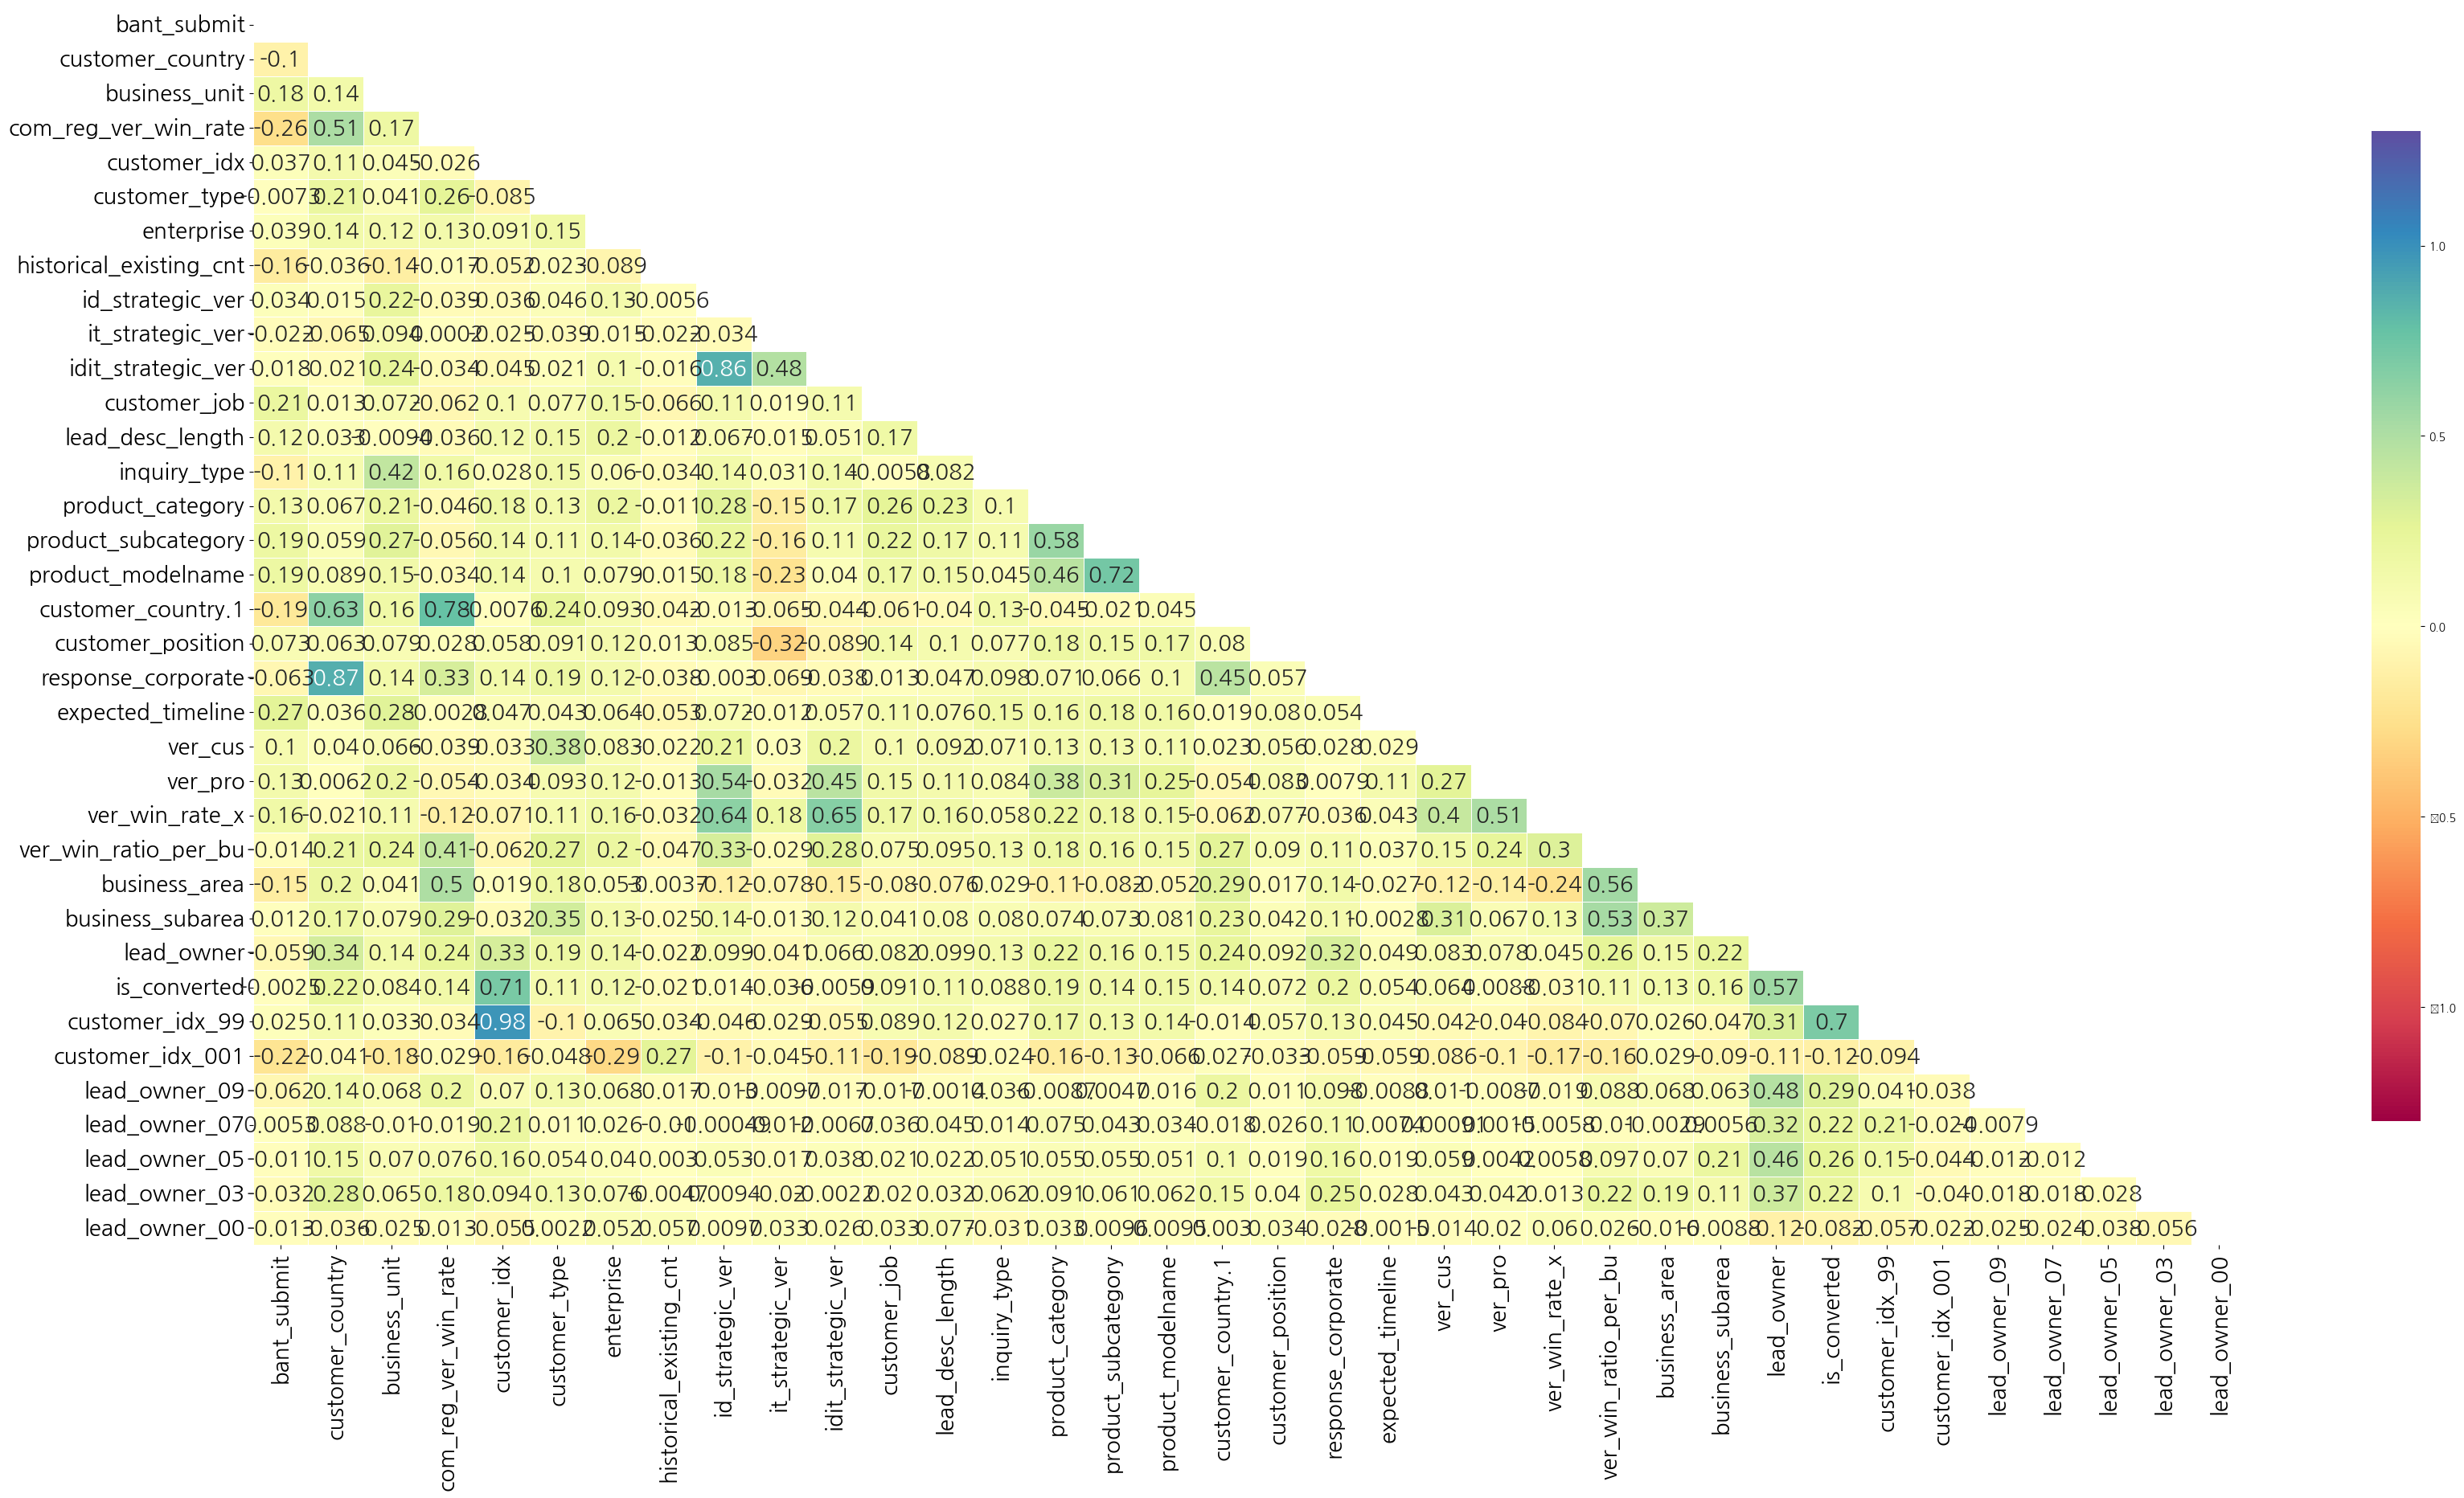

In [69]:
import numpy as np

# 숫자형 변수들 간의 상관관계 계산
corr = df_train_encoded.corr()

# 상관계수 행렬의 상삼각행렬을 마스킹하기 위한 마스크 생성
mask = np.triu(np.ones_like(corr, dtype=bool))

# 히트맵
plt.figure(figsize=(40, 20))

sns.heatmap(corr,
            mask=mask, # 마스크 적용
            annot=True, # 수치(상관관계) 표시
            annot_kws = {'size':20}, # 수치표시 사이즈
            cmap='Spectral', # 색상 변경
            vmin=-1.3, # 색상 팔레트 범위
            vmax=1.3,
            linewidths=.5, # 히트맵의 선 스타일 변경
            cbar_kws={"shrink": .8}) # 히트맵 주변에 색상 바 추가(사이즈 조절 가능)

# 변수 이름의 크기 조절
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()


의미없다고 판단되는 변수 drop

In [70]:
df_train_encoded = df_train_encoded.drop(['customer_country','product_modelname'], axis=1)
df_test_encoded = df_test_encoded.drop(['customer_country','product_modelname'], axis=1) 

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속 변수와 독립 변수를 분리합니다.
y = df_train_encoded['is_converted']
X = df_train_encoded.drop(['is_converted'], axis=1)

# 각 독립 변수의 VIF를 계산합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

    VIF Factor                 features
0     8.234850              bant_submit
1    22.403693            business_unit
2     5.476924     com_reg_ver_win_rate
3    46.500317             customer_idx
4    11.835249            customer_type
5     7.879998               enterprise
6     1.236411  historical_existing_cnt
7          inf         id_strategic_ver
8          inf         it_strategic_ver
9          inf       idit_strategic_ver
10   12.904692             customer_job
11    1.589648         lead_desc_length
12   16.175253             inquiry_type
13    6.795455         product_category
14   10.450971      product_subcategory
15   17.178351       customer_country.1
16   19.582806        customer_position
17    4.491151       response_corporate
18   31.734373        expected_timeline
19    1.586952                  ver_cus
20    1.801374                  ver_pro
21    3.116336           ver_win_rate_x
22    3.081903     ver_win_ratio_per_bu
23   12.660682            business_area


### 최종적으로 선정된 변수

In [72]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   business_unit            59299 non-null  float64
 2   com_reg_ver_win_rate     59299 non-null  float64
 3   customer_idx             59299 non-null  float64
 4   customer_type            59299 non-null  float64
 5   enterprise               59299 non-null  float64
 6   historical_existing_cnt  59299 non-null  float64
 7   id_strategic_ver         59299 non-null  float64
 8   it_strategic_ver         59299 non-null  float64
 9   idit_strategic_ver       59299 non-null  float64
 10  customer_job             59299 non-null  float64
 11  lead_desc_length         59299 non-null  float64
 12  inquiry_type             59299 non-null  float64
 13  product_category         59299 non-null  float64
 14  product_subcategory   

In [73]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5271 non-null   int64  
 1   bant_submit              5271 non-null   float64
 2   business_unit            5271 non-null   float64
 3   com_reg_ver_win_rate     5271 non-null   float64
 4   customer_idx             5271 non-null   float64
 5   customer_type            5271 non-null   float64
 6   enterprise               5271 non-null   float64
 7   historical_existing_cnt  5271 non-null   float64
 8   id_strategic_ver         5271 non-null   float64
 9   it_strategic_ver         5271 non-null   float64
 10  idit_strategic_ver       5271 non-null   float64
 11  customer_job             5271 non-null   float64
 12  lead_desc_length         5271 non-null   float64
 13  inquiry_type             5271 non-null   float64
 14  product_category        

In [74]:
df_train_encoded.to_csv('./data/Ch3/df_train_encoded.csv', index=False)
df_test_encoded.to_csv('./data/Ch3/df_test_encoded.csv', index=False)

.